In [1]:
import pandas as pd
import ast
import glob
import os

import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_excel("../preprocessed_cars/new_cleaned_entire_dataset.xlsx")

In [3]:
def encoding_datas(df):
    le = LabelEncoder()
    df['Insurance_Validity_Period'] = le.fit_transform(df['Insurance_Validity_Period'])
    nominal_cols = ['Car_Model', 'Fuel_Type', 'Transmission_Type', 'Battery_Type', 'city']
    df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
    boolean_cols = df.select_dtypes(include=['bool']).columns
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

In [4]:
def replace_integers(x):
    if isinstance(x, int):
        return 'unknown'
    elif isinstance(x, float):
        return 'unknown'
    else:
        return x

In [5]:
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x 

In [6]:
def one_hot_encode_list_columns(df):
    one_hot_encoded_df = pd.DataFrame()
    list_like_cols = ['Top_Features', 'Comfort_and_Convenience', 'Interior_Features', 'Exterior_Features', 'Safety_Features', 'Entertainment_and_Communication']

    for col in list_like_cols:
        df[col] = df[col].apply(replace_integers)
        df[col] = df[col].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else x)
        # Extract unique features
        unique_features = set()
        for features in df[col]:
            unique_features.update(features)

        unique_features = list(unique_features)

        # Create a DataFrame for one-hot encoded columns
        one_hot_encoded_df = pd.DataFrame()

        for feature in unique_features:
            one_hot_encoded_df[f'{col}_{feature}'] = df[col].apply(lambda x: 1 if feature in x else 0)

        # Concatenate the new DataFrame with the original DataFrame
        df = pd.concat([df.drop(columns=[col]), one_hot_encoded_df], axis=1)
        
    return df

In [7]:
df = one_hot_encode_list_columns(df)

In [8]:
df = encoding_datas(df)

In [9]:
numerical_columns = ['Number_of_Seats', 'Mileage_(km/l)', 'Engine_Capacity', 'Maximum_Power', 
                         'Torque', 'Wheel_Size', 'Kilometers_Driven', 'Number_of_Owners', 
                         'Model_Year', 'Listed_Price', 'Actual_Price']

In [10]:
summary_stats = df[numerical_columns].dtypes

In [11]:
summary_stats

Number_of_Seats        int64
Mileage_(km/l)       float64
Engine_Capacity      float64
Maximum_Power        float64
Torque               float64
Wheel_Size           float64
Kilometers_Driven      int64
Number_of_Owners       int64
Model_Year             int64
Listed_Price         float64
Actual_Price         float64
dtype: object

In [12]:
df.select_dtypes(exclude=['int64', 'float64']).columns

Index([], dtype='object')

In [13]:
## Descriptive Statistics
df[numerical_columns].describe()

,Number_of_Seats,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Kilometers_Driven,Number_of_Owners,Model_Year,Listed_Price,Actual_Price
count,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8.369000e+03
mean,5.203131,19.252806,1424.670496,7.647381e+05,179.137514,15.692528,5.897430e+04,1.360139,2016.503286,8.890303e+07,8.893126e+07
std,0.663573,3.961567,477.816936,3.353721e+07,108.431513,1.229770,7.406100e+04,0.641958,3.921465,7.914973e+08,7.914978e+08
min,2.000000,7.080000,0.000000,2.540000e+01,7.800000,12.000000,0.000000e+00,0.000000,1985.000000,1.000000e+05,1.194336e+05
25%,5.000000,17.010000,1197.000000,7.890000e+01,111.700000,15.000000,3.000000e+04,1.000000,2014.000000,4.000000e+05,4.310932e+05
50%,5.000000,19.000000,1248.000000,8.870000e+01,144.000000,15.683188,5.369200e+04,1.000000,2017.000000,6.190000e+05,6.460000e+05
75%,5.000000,21.400000,1498.000000,1.213000e+02,215.000000,16.000000,8.000000e+04,2.000000,2019.000000,9.750000e+05,1.007093e+06
max,10.000000,140.000000,5000.000000,1.652244e+09,850.000000,21.000000,5.500000e+06,5.000000,2023.000000,9.970300e+09,9.970335e+09


Data Visualization

In [14]:
corr_numerical = df[numerical_columns].corr()


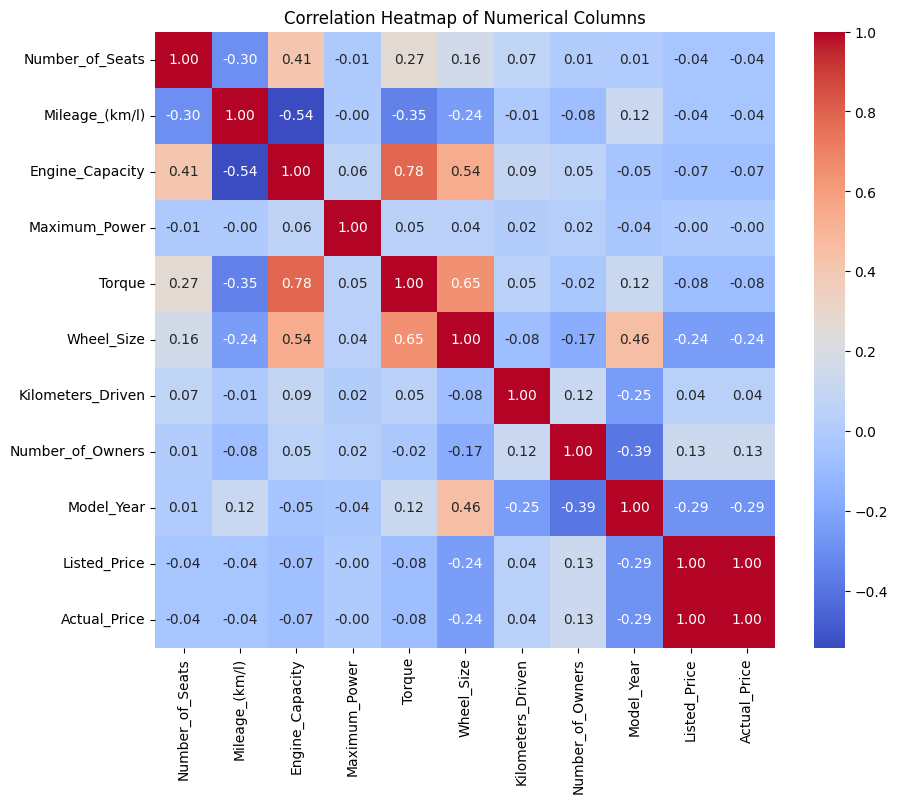

In [15]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_numerical, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [16]:
# # Calculate correlation matrix
# corr_combined = df.corr()

# # Plot heatmap
# plt.figure(figsize=(15, 10))
# sns.heatmap(corr_combined, annot=False, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Numerical + One-Hot Encoded Columns')
# plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you are predicting a numerical target variable
X = df.drop('Listed_Price', axis=1)  # Features
y = df['Listed_Price']               # Target variable

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [ ]:
zero_importance_features = feature_importances[feature_importances['Importance'] == 0]['Feature']

In [ ]:
zero_importance_features

571           Car_Model_Toyota Fortuner Legender
48                     Top_Features_Rear Spoiler
52     Top_Features_Multifunction Steering Wheel
311                Car_Model_Chevrolet Aveo U-VA
40               Top_Features_Engine Immobilizer
                         ...                    
517                    Car_Model_Porsche Cayenne
516                        Car_Model_Porsche 911
379                         Car_Model_Isuzu MU 7
507               Car_Model_Mitsubishi Outlander
309                             Car_Model_BMW X7
Name: Feature, Length: 85, dtype: object

In [ ]:
df_reduced = df.drop(columns=zero_importance_features)

In [ ]:
# # Calculate correlation matrix
# corr_combined = df_reduced.corr()

# # Plot heatmap
# plt.figure(figsize=(15, 10))
# sns.heatmap(corr_combined, annot=False, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Numerical + One-Hot Encoded Columns')
# plt.show()

In [ ]:
numerical_columns

In [99]:
# Pairplot

sns.pairplot(df_reduced[numerical_columns])  # numerical_columns is a list of your numerical column names
plt.show()

In [24]:
numerical_columns

['Number_of_Seats',
 'Mileage_(km/l)',
 'Engine_Capacity',
 'Maximum_Power',
 'Torque',
 'Wheel_Size',
 'Kilometers_Driven',
 'Number_of_Owners',
 'Model_Year',
 'Listed_Price',
 'Actual_Price']

In [46]:
z_scores = stats.zscore(df[numerical_columns])

In [48]:
z_df = pd.DataFrame(z_scores, columns=numerical_columns)

In [49]:
# Find outliers (e.g., Z-score > 3 or < -3)
outliers = (z_df.abs() > 3).any(axis=1)

In [50]:
# Filter outliers from the original DataFrame
df_outliers = df[outliers]

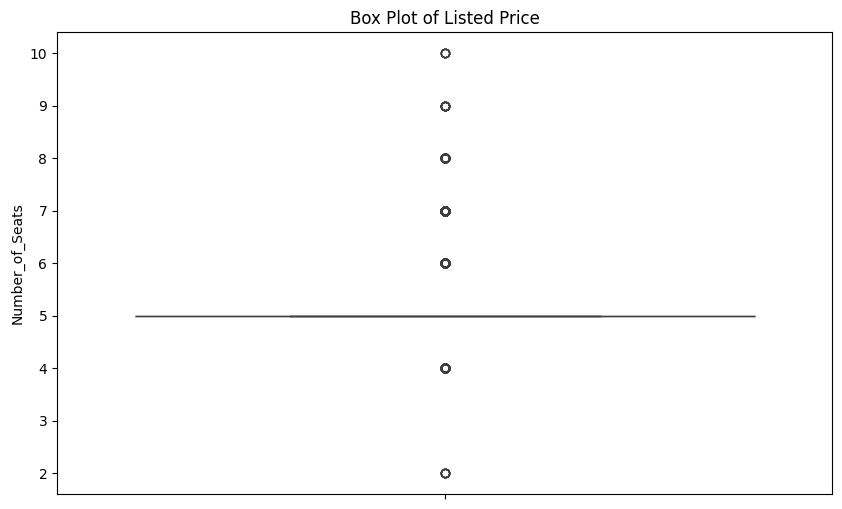

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['Number_of_Seats'])
plt.title('Box Plot of Listed Price')
plt.show()

In [77]:
#descriptive  statistics
df.describe()

,Unnamed: 0,Number_of_Seats,Mileage_(km/l),Engine_Capacity,Maximum_Power,Torque,Wheel_Size,Kilometers_Driven,Number_of_Owners,Model_Year,...,Entertainment_and_Communication_Speakers Rear,Entertainment_and_Communication_Number Of Speaker,Entertainment_and_Communication_o,Entertainment_and_Communication_Dvd Player,Entertainment_and_Communication_Speakers Front,Entertainment_and_Communication_Android Auto,Entertainment_and_Communication_Integrated2Din Audio,Entertainment_and_Communication_Touch Screen,Entertainment_and_Communication_Apple Car Play,Entertainment_and_Communication_Wireless Phone Charging
count,8369.000000,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,...,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000
mean,4184.000000,5.203131,19.252806,1424.670496,7.647381e+05,179.137514,15.692528,5.897430e+04,1.360139,2016.503286,...,0.788983,0.514637,0.130840,0.055801,0.855897,0.168957,0.622297,0.413311,0.168479,0.059744
std,2416.066535,0.663573,3.961567,477.816936,3.353721e+07,108.431513,1.229770,7.406100e+04,0.641958,3.921465,...,0.408055,0.499816,0.337245,0.229551,0.351215,0.374736,0.484842,0.492457,0.374313,0.237027
min,0.000000,2.000000,7.080000,0.000000,2.540000e+01,7.800000,12.000000,0.000000e+00,0.000000,1985.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2092.000000,5.000000,17.010000,1197.000000,7.890000e+01,111.700000,15.000000,3.000000e+04,1.000000,2014.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4184.000000,5.000000,19.000000,1248.000000,8.870000e+01,144.000000,15.683188,5.369200e+04,1.000000,2017.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6276.000000,5.000000,21.400000,1498.000000,1.213000e+02,215.000000,16.000000,8.000000e+04,2.000000,2019.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,8368.000000,10.000000,140.000000,5000.000000,1.652244e+09,850.000000,21.000000,5.500000e+06,5.000000,2023.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


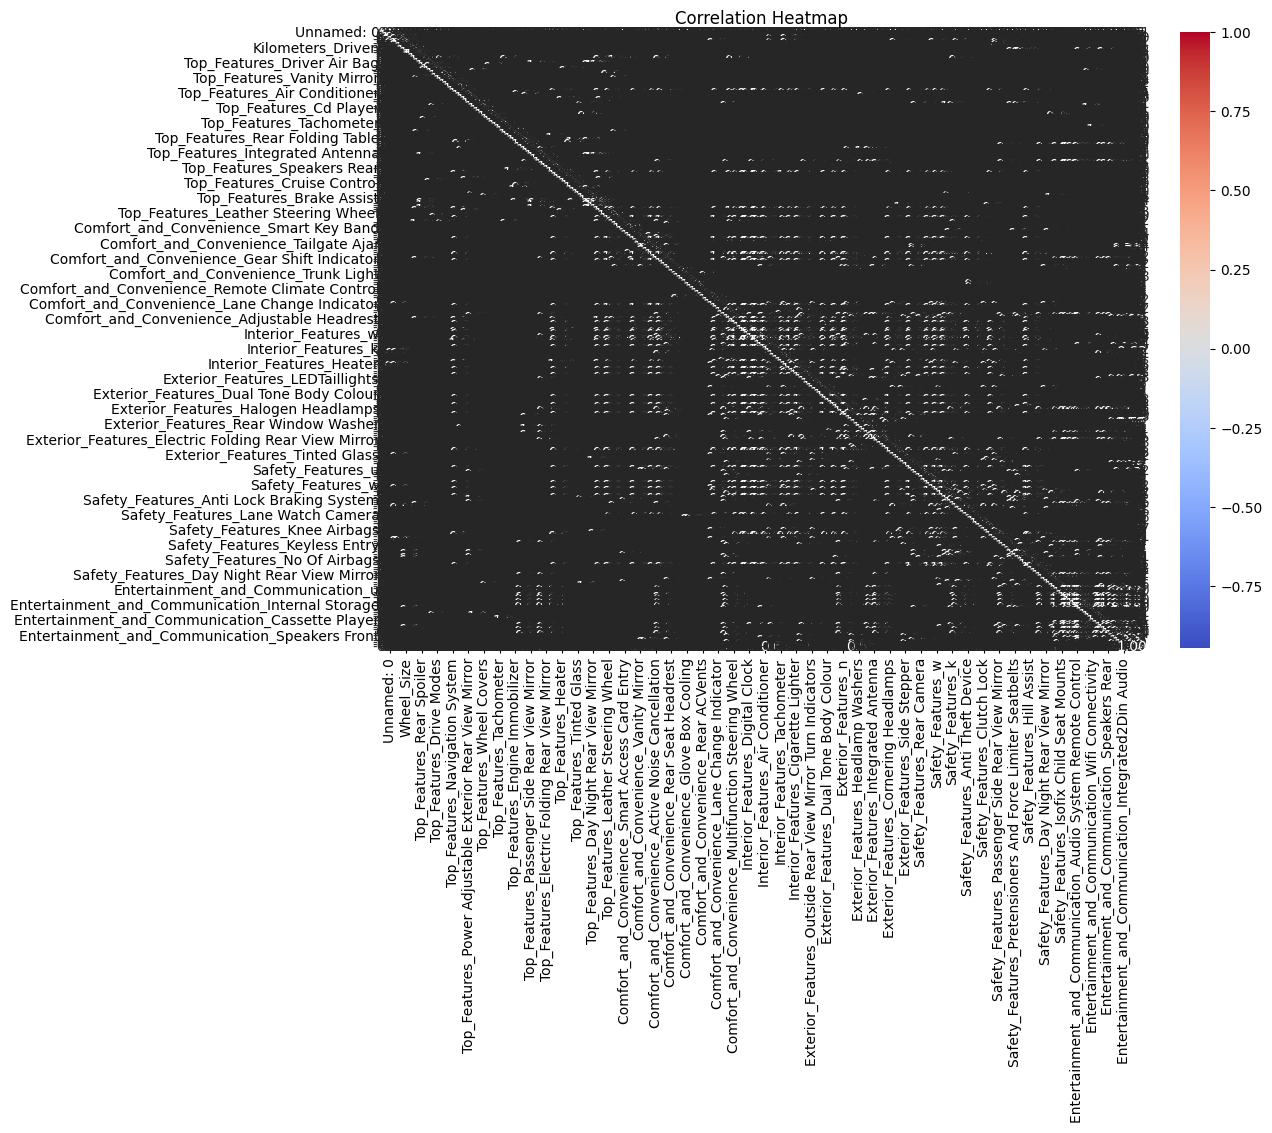

In [79]:
#Data Visualization
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation
plt.figure(figsize=(12,8))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()